In [31]:
from collections import defaultdict
import gym
from gym import spaces
from itertools import islice, tee
import numpy as np
import operator
from tqdm import tqdm


## LoCA Environment and Evaluation

class LoCAEnv(gym.Env):
    def enter_phase_two(self):
        raise NotImplementedError

class LoCATwoStageMDP(LoCAEnv):
    metadata = {"render_modes": ["ansi"], "render_fps": 4}
    # Probabilities of transition from state 0 to states 1 and 2.
    probabilities = [
        # Action 0 - "Left". 70% chance to transition to state 1, 30% chance to transition to state 2.
        [0.7, 0.3], 
        # Action 1 - "Right". 30% chance to transition to state 1, 70% chance to transition to state 2.
        [0.3, 0.7]
    ]

    rewards = [
        # Rewards in phase one. State 1 is optimal.
        {0: 0, 1: 4, 2: 2 },
        # Rewards in phase two. State 2 is optimal.
        {0: 0, 1: 1, 2: 2},
    ];

    def __init__(self, render_mode=None):
        self.observation_space = spaces.Discrete(3)
        self.action_space = spaces.Discrete(2)

        # self.reward_distributions = tuple(map(lambda x: tuple(unzip(x.items())), rewards))
        # self.episodic = episodic

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.loca_phase = 1
    
    def _get_obs(self):
        return self._current_state

    def _get_info(self):
        return None

    def enter_phase_two(self):
        self.loca_phase = 2
        self._current_state = 1
        return self._get_obs(), self._get_info()  

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0

        # Reset to 
        self.loca_phase = 1
        self._current_state = 0

        return self._get_obs(), self._get_info()
    def step(self, action):
        self.step_count += 1
        if self._current_state == 0:
            self._current_state = self.np_random.choice([1,2], p=self.probabilities[action])
            return self._current_state, 0, False, False, self._get_info()
        else:
            reward = self.rewards[self.loca_phase-1][self._current_state]
            if self.loca_phase == 2: 
                self._current_state = 1
            else:
                self._current_state = 0
            return self._current_state, reward, False, False, self._get_info()  



In [56]:
class RMaxAgent:
    def __init__(self, env, n_states, n_actions, m, gamma=0.99):
      # initializes the agent with the given environment, 
      #number of states, number of actions
      #the parameter m (number of visits needed to update Q-values). 
     
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        self.m = m
        self.gamma = gamma

 #initializes Q-values, transition_counts, reward_counts, and K (number of times the agent has executed action a in state s)
        self.Q = np.full((n_states, n_actions), float('inf'))
        self.transition_counts = np.zeros((n_states, n_actions, n_states))
        self.reward_counts = np.zeros((n_states, n_actions, n_states))
        self.K = np.zeros((n_states, n_actions))

    def update_Q(self, s, a, s_prime, r):
#updates the transition_counts and reward_counts. 
        self.transition_counts[s, a, s_prime] += 1
        self.reward_counts[s, a, s_prime] += r
        self.K[s, a] += 1
#if the agent has executed action a in state s for m times, updates the Q-values using the learned model of the environment 
        if self.K[s, a] == self.m:
            for s_p in range(self.n_states):
                self.Q[s, a] = (self.reward_counts[s, a, s_p] / self.K[s, a]) + self.gamma * np.sum(
                    self.transition_counts[s, a, s_p] / self.K[s, a] * np.max(self.Q[s_p, :])
                )

#This method selects an action based on the agent's current state (s).
    def select_action(self, s, explore=True):
#If the agent is set to explore and has not explored all actions in the current state, it selects a random unexplored action. 
        if explore and np.any(self.Q[s, :] == float('inf')):
            return np.random.choice(np.where(self.Q[s, :] == float('inf'))[0])
#Otherwise, it selects the action with the highest Q-value. 
        else:
            return np.argmax(self.Q[s, :])
#returns the agent's action without exploration, given the current state.
    def get_action(self, state):
        return self.select_action(state, explore=False)


    def train(self, n_episodes, max_steps_per_episode, verbose=False):
        self.rewards_per_episode_phase1 = []
        self.rewards_per_episode_phase2 = []

        for episode in range(n_episodes):
            obs, _ = self.env.reset()
            done = False
            step_count = 0
            episode_reward_phase1 = 0
            episode_reward_phase2 = 0

#For each episode, it resets the environment and iterates through steps until the episode ends or the maximum number of steps is reached
            while not done and step_count < max_steps_per_episode:
              # Agent selects an action, performs the action, and updates the Q-values. 
                action = self.select_action(obs)
                next_obs, reward, done, _, _ = self.env.step(action)
                self.update_Q(obs, action, next_obs, reward)
# see what happend for Phase II
                if verbose:
                    phase = "Phase I" if step_count <= max_steps_per_episode // 2 else "Phase II"
                    print(f"[{phase}] Episode {episode}, Step {step_count}: State {obs}, Action {action}, Reward {reward}")

                obs = next_obs
                step_count += 1

#When the agent reaches the middle of the episode, it enters Phase II. 
                if step_count == max_steps_per_episode // 2:
                    obs, _ = self.env.enter_phase_two()

                if step_count <= max_steps_per_episode // 2:
                    episode_reward_phase1 += reward
                else:
                    episode_reward_phase2 += reward

            self.rewards_per_episode_phase1.append(episode_reward_phase1)
            self.rewards_per_episode_phase2.append(episode_reward_phase2)


In [55]:
class QLearningAgent:
    def __init__(self, env, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        self.Q = np.zeros((n_states, n_actions))


#updates the Q values by calling the update_Q function, 
#which uses the Bellman equation to compute the TD target and error, 
#and updates the Q value for the current state-action pair accordingly.
    def update_Q(self, s, a, s_prime, r):
        td_target = r + self.gamma * np.max(self.Q[s_prime, :])
        td_error = td_target - self.Q[s, a]
        self.Q[s, a] += self.alpha * td_error

#selects the action with the highest Q value for a given state, with probability (1-epsilon), and a random action with probability epsilon.
 #This ensures that the agent explores the state space sufficiently while still learning the optimal policy.
    def select_action(self, s):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[s, :])
    def get_action(self, state):
            return np.argmax(self.Q[state, :])


    def train(self, n_episodes, max_steps_per_episode, verbose=False):
        self.rewards_per_episode_phase1 = []
        self.rewards_per_episode_phase2 = []

        for episode in range(n_episodes):
            obs, _ = self.env.reset()
            done = False
            step_count = 0
            episode_reward_phase1 = 0
            episode_reward_phase2 = 0

            while not done and step_count < max_steps_per_episode:
                action = self.select_action(obs)
                next_obs, reward, done, _, _ = self.env.step(action)
                self.update_Q(obs, action, next_obs, reward)
#phase II
                if verbose:
                    phase = "Phase I" if step_count <= max_steps_per_episode // 2 else "Phase II"
                    print(f"[{phase}] Episode {episode}, Step {step_count}: State {obs}, Action {action}, Reward {reward}")



                obs = next_obs
                step_count += 1

                if step_count == max_steps_per_episode // 2:
                    obs, _ = self.env.enter_phase_two()

                if step_count <= max_steps_per_episode // 2:
                    episode_reward_phase1 += reward
                else:
                    episode_reward_phase2 += reward

            self.rewards_per_episode_phase1.append(episode_reward_phase1)
            self.rewards_per_episode_phase2.append(episode_reward_phase2)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
def naive_loca_eval(agent, env):
    def train_agent(agent, env, obs, n_actions):
        for _ in range(n_actions):
            action = agent.select_action(obs)
            next_obs, reward, done, _, _ = env.step(action)
            agent.update_Q(obs, action, next_obs, reward)
            obs = next_obs

    obs, _ = env.reset()
    # Train on phase one
    train_agent(agent, env, obs, n_actions=20000)
    # Sample action in state 0. Should yield 0. See probabilities and rewards above.
    sample1 = agent.get_action(0)
    print(sample1, " -- Phase One: ", "PASS" if sample1 == 0 else "FAIL")

    # Now enter LoCA phase two
    obs, _ = env.enter_phase_two()
    # Train on phase two
    train_agent(agent, env, obs, n_actions=20000)

    # Sample action in state 0. Should now yield 1, if agent is adaptive. See probabilities and rewards above.
    sample2 = agent.get_action(0)
    print(sample2, " -- Phase Two: ", "PASS" if sample2 == 1 else "FAIL")


In [ ]:
n_states = 3
n_actions = 2
n_episodes = 100
max_steps_per_episode = 100
m = 10

env1 = LoCATwoStageMDP()
q_agent = QLearningAgent(env1, n_states, n_actions)
q_agent.train(n_episodes, max_steps_per_episode, verbose=True)
print(naive_loca_eval(q_agent, env))

env2 = LoCATwoStageMDP()
rmax_agent = RMaxAgent(env2, n_states, n_actions, m)
rmax_agent.train(n_episodes, max_steps_per_episode,verbose=True)
print(naive_loca_eval(rmax_agent, env))


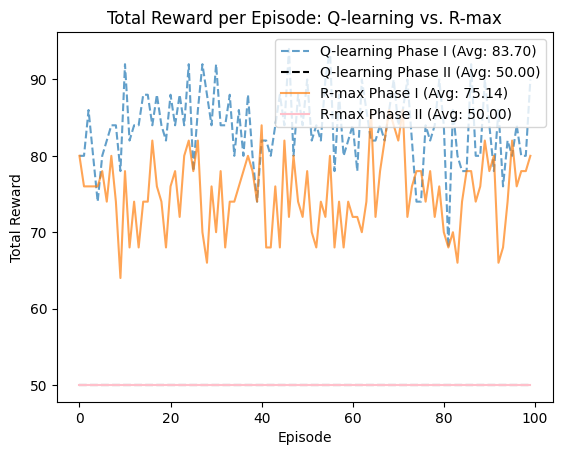

In [63]:
import numpy as np

# Calculate the average reward per episode for each phase
q_learning_phase1_avg = np.mean(q_agent.rewards_per_episode_phase1)
q_learning_phase2_avg = np.mean(q_agent.rewards_per_episode_phase2)
rmax_phase1_avg = np.mean(rmax_agent.rewards_per_episode_phase1)
rmax_phase2_avg = np.mean(rmax_agent.rewards_per_episode_phase2)

# Plot the average rewards
plt.plot(q_agent.rewards_per_episode_phase1, label=f"Q-learning Phase I (Avg: {q_learning_phase1_avg:.2f})", linestyle="--", alpha=0.7)
plt.plot(q_agent.rewards_per_episode_phase2, label=f"Q-learning Phase II (Avg: {q_learning_phase2_avg:.2f})", linestyle="--",color='black')
plt.plot(rmax_agent.rewards_per_episode_phase1, label=f"R-max Phase I (Avg: {rmax_phase1_avg:.2f})", alpha=0.7)
plt.plot(rmax_agent.rewards_per_episode_phase2, label=f"R-max Phase II (Avg: {rmax_phase2_avg:.2f})", color = 'pink')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode: Q-learning vs. R-max')
plt.legend()
plt.show()
